## THIS IS THE FOURTH NOTEBOOK FOR THE FINAL PROJECT

In [12]:
from tpqoa import tpqoa

import numpy as np
import pandas as pd

import tables as tb
import tstables as tstb
import pickle

import datetime
import time
import logging

from sklearn import linear_model

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

logging.basicConfig(filename="tradingstrategy.log",level=logging.DEBUG,
                    format="%(asctime)s %(name)s.%(funcName)s +%(lineno)s: %(levelname)-8s %(message)s", 
                    datefmt ='%d/%m/%y %I:%M:%S %P')

In [2]:
class tradingstrategy(tpqoa):
    '''class for trading strategy using lagged returns, rsi and macd
    indicators. Optimised using logistic regression.
    '''
    def __init__(self, conf_file, instrument):
        tpqoa.__init__(self, conf_file)
        self.instrument = instrument
        self.live_data = pd.DataFrame()
        self.position = 0
        self.ticks = 0
        self.units = 100000
        self.rsi_n = 21
        self.mom1 = 2
        self.mom2 = 5
        self.lags = 20
        self.model = linear_model.LogisticRegression()
        
    def stream_data(self, stop = None):
        # self.stoptime = datetime.datetime(2018, 5, 25, 4, 0, 0, 0)
        ''' starts a real time Oanda data stream'''
        self.ticks = 0
        response = self.ctx_stream.pricing.stream(self.account_id, snapshot = True,
                                                 instruments = self.instrument)
        for msg_type, msg in response.parts():
            if msg_type == 'pricing.Price':
                self.on_success(msg.time,
                              float(msg.bids[0].price),
                              float(msg.asks[0].price))
                if stop is not None:
                    if self.ticks >= stop:
                        logging.info('stop reached')

                        # stop reached close out long position
                        if self.position == 1:
                            self.create_order(self.instrument,
                                             units = -self.units)
                            logging.info('stop reached - closing long, no open positions| %s | units %4d' 
                                         % (self.instrument, self.units))
                            print('stop reached - closing long, no open positions')  
                            % (self.instrument, self.units))
                            self.position = 0
                            
                        # stop reached close out short position
                        elif self.position == -1:
                            self.create_order(self.instrument,
                                             units = self.units)
                            logging.info('stop reached - closing short, no open position| %s | units %4d'
                                         % (self.instrument, self.units))
                            print('stop reached - closing short, no open positions')
                            self.position = 0
                            
                        print(15 * '-')
                        print('Trading has stopped')
                        print(15 * '-')                           
                        break
                            
    def on_success(self, time, bid, ask):
        '''Method called when new data is received. This updates the on_success
        method originally in the tpqoa class inherited by tradingstrategy class
        which merely printed and timestamped bid and ask prices'''
        self.ticks += 1
        if self.ticks % 5 == 0:
            print('%3d | '% self.ticks, time, bid, ask)
            
        self.live_data = self.live_data.append(pd.DataFrame({'bid':bid, 
                                                             'ask': ask},
                                                            index = [pd.Timestamp(time)]))
        self.dataresam = self.live_data.resample('5s', label = 'right').last().ffill().iloc[:-1]
        self.dataresam['mid'] = self.dataresam.mean(axis=1)
        self.dataresam['returns'] = np.log(self.dataresam['mid'] / self.dataresam['mid'].shift(1))
        if len(self.dataresam) > 22: # self.mom2: ******************************
                                                # *****************************
            self.dataresam['RSI'] = self.relative_strength(self.dataresam['mid'], self.rsi_n)
            self.dataresam['MACD'] = self.macd(self.dataresam['mid'])
            self.dataresam = self.prepare_features(self.dataresam, self.lags)
            self.load_model()
    
    def load_model(self):
        LinMod = pickle.load(open('final_model.sav','rb'))
        pred = LinMod.predict(self.dataresam[self.cols])
        self.dataresam['prediction'] = pred
        self.execute_order()
        
    def execute_order(self):
        # Entering long
        if self.dataresam['prediction'].iloc[-2] > 0 and self.position == 0:
            print('going long')
            self.position = 1
            self.create_order(self.instrument, self.units)
            logging.info('going long | %s | units %4d' % (self.instrument, self.units))
            
        elif self.dataresam['prediction'].iloc[-2] > 0 and self.position == -1:
            print('covering short and going long')
            self.position = 1
            self.create_order(self.instrument, 2 * self.units)
            logging.info('covering short and going long | %s | units %4d' % (self.instrument, self.units))
            
        # Entering short
        elif self.dataresam['prediction'].iloc[-2] < 0 and self.position == 0:
            print('going short')
            self.position = -1
            self.create_order(self.instrument, units = -self.units)
            logging.info('going short | %s | units %4d' % (self.instrument, self.units))
            
        elif self.dataresam['prediction'].iloc[-2] < 0 and self.position == 1:
            print('covering long and going short')
            self.position = -1
            self.create_order(self.instrument, units = -2 * self.units)
            logging.info('covering long and going short | %s | units %4d' % (self.instrument, self.units))      
                
    def relative_strength(self, data, rsi_n):
        '''Creates RSI feature -
        initial RSI value created here'''
        abchange = (data - data.shift(1)) # calculate absolute daily change
        rsperiod = abchange[:rsi_n + 1]
        upday = rsperiod[rsperiod >= 0].sum() / rsi_n # in the RSI period what is the up day change
        dnday = -rsperiod[rsperiod < 0].sum() / rsi_n # in the RSI period what is the down day change
        rs = upday / dnday # up day change/down day change ratio
        rsi = np.zeros_like(data)
        rsi[:rsi_n] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
        
        '''calculates subsequent change in RSI values'''
        for i in range(rsi_n, len(data)):
            abchg = abchange[i - 1]
            if abchg > 0:
                upval = abchg
                dnval = 0
            else:
                upval = 0
                dnval = abs(abchg)
            
            # iterate through each daily change proportionally adding it
            # to the respective RSI period change
            upday = (upday * (rsi_n - 1) + upval) / rsi_n
            dnday = (dnday * (rsi_n - 1) + dnval) / rsi_n
            
            rs = upday / dnday # up day change/down day change ratio
            rsi[i] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
        
        
        rsi = pd.DataFrame(rsi)
        rsi.index = data.index
        rsi.columns = ['RSI']
        return rsi # Return the RSI Index value calculated
    
    def macd(self, data, slow = 26, fast = 12, signal = 9):
        # calculate respective fast and slow exponential moving averages
        ema_fast = data.ewm(span = fast).mean()
        ema_slow = data.ewm(span = slow).mean()
        # MACD line is slow m.a. minus fast m.a.
        macd_line = ema_slow - ema_fast
        # signal line is 9 day ema of macd line
        sig_line = macd_line.ewm(span = signal).mean()
        # macd histogram is the macd line minus the signal line
        macd_hist = macd_line - sig_line
        macd_hist = pd.DataFrame(macd_hist)
        macd_hist.columns = ['MACD']
        return macd_hist
            
    def prepare_features(self, df, lagz):
        '''creates lagged and momentum features'''
        self.cols = []
        
        #self.features = ['RSI','MACD','Returns']
        # add lagged RSI and MACD data, backtest suggests 1
        # lagged return only
        for feat1 in ['RSI','MACD']:
            lag1 = 1
            col = '%s_lag_%d' % (feat1, lag1)
            df[col] = df[feat1].shift(lag1)
            self.cols.append(col)
            
        # add lagged return data, backtest suggests 20
        # lagged returns        
        for lag in range(1,lagz + 1):
            col = 'Returns_lag_%d' % lag
            df[col] = df['returns'].shift(lag)
            self.cols.append(col)
            
        # add short term momentum signal
        df['MOM1'] = np.where(df['returns'].rolling(self.mom1).mean() > 0, 1, 0)
        df['MOM1'] = df['MOM1'].shift(1)
        self.cols.append('MOM1')
        # add long term momentum signal
        df['MOM2'] = np.where(df['returns'].rolling(self.mom2).mean() > 0, 1, 0)
        df['MOM2'] = df['MOM2'].shift(1)
        self.cols.append('MOM2')
        df.dropna(inplace = True)
        return df        
        

In [3]:
rt = tradingstrategy('/root/pyalgo.cfg','AUD_USD')

In [4]:
rt.stream_data(stop = 100)

  5 |  2018-05-28T05:49:48.631369775Z 0.75776 0.75789
 10 |  2018-05-28T05:50:03.196970321Z 0.75784 0.75798
 15 |  2018-05-28T05:50:32.653991949Z 0.75784 0.75798
going short


 {'id': '2248', 'time': '2018-05-28T05:51:02.221739288Z', 'userID': 8094291, 'accountID': '101-011-8094291-001', 'batchID': '2247', 'requestID': '78464337456480485', 'type': 'ORDER_FILL', 'orderID': '2247', 'instrument': 'AUD_USD', 'units': '-100000.0', 'price': '0.75777', 'fullPrice': {'bids': [{'price': '0.75777', 'liquidity': '10000000'}], 'asks': [{'price': '0.75791', 'liquidity': '10000000'}], 'closeoutBid': '0.75762', 'closeoutAsk': '0.75806', 'timestamp': '2018-05-28T05:51:00.932522378Z'}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'accountBalance': '99521.3052', 'tradeOpened': {'tradeID': '2248', 'units': '-100000.0'}} 

 20 |  2018-05-28T05:51:02.721739288Z 0.75777 0.75791
covering short and going long


 {'id': '2250', 'time': '2018-05-28T05:51:17.227366566Z', 'userI

 85 |  2018-05-28T05:59:37.920909651Z 0.75766 0.75779
covering long and going short


 {'id': '2268', 'time': '2018-05-28T06:00:12.716798974Z', 'userID': 8094291, 'accountID': '101-011-8094291-001', 'batchID': '2267', 'requestID': '78464339763771535', 'type': 'ORDER_FILL', 'orderID': '2267', 'instrument': 'AUD_USD', 'units': '-200000.0', 'price': '0.75771', 'fullPrice': {'bids': [{'price': '0.75771', 'liquidity': '10000000'}], 'asks': [{'price': '0.75785', 'liquidity': '10000000'}], 'closeoutBid': '0.75756', 'closeoutAsk': '0.758', 'timestamp': '2018-05-28T06:00:12.321876116Z'}, 'reason': 'MARKET_ORDER', 'pl': '-10.5581', 'financing': '-0.0033', 'commission': '0.0', 'accountBalance': '99357.6609', 'tradeOpened': {'tradeID': '2268', 'units': '-100000.0'}, 'tradesClosed': [{'tradeID': '2266', 'units': '-100000.0', 'realizedPL': '-10.5581', 'financing': '-0.0033'}]} 

 90 |  2018-05-28T06:00:13.216798974Z 0.75771 0.75785
covering short and going long


 {'id': '2270', 'time': '2018-05-28T

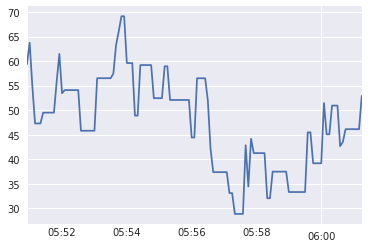

In [5]:
rt.dataresam['RSI'].plot()

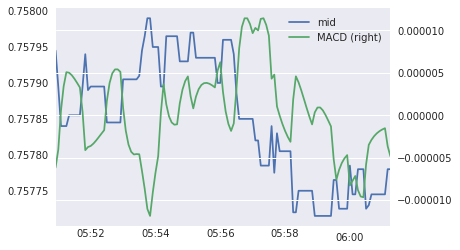

In [6]:
rt.dataresam[['mid','MACD']].plot(secondary_y = 'MACD')

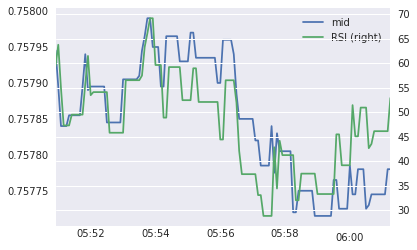

In [7]:
rt.dataresam[['mid','RSI']].plot(secondary_y='RSI')

In [8]:
rt.dataresam

,ask,bid,mid,returns,RSI,MACD,RSI_lag_1,MACD_lag_1,Returns_lag_1,Returns_lag_2,...,Returns_lag_14,Returns_lag_15,Returns_lag_16,Returns_lag_17,Returns_lag_18,Returns_lag_19,Returns_lag_20,MOM1,MOM2,prediction
2018-05-28 05:50:55+00:00,0.75802,0.75787,0.757945,0.000046,59.375000,-6.131826e-06,59.375000,-4.530920e-06,0.000000,0.000000,...,-0.000073,-0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,-1.0
2018-05-28 05:51:00+00:00,0.75796,0.75783,0.757895,-0.000066,63.746645,-4.033989e-06,59.375000,-6.131826e-06,0.000046,0.000000,...,0.000020,-0.000073,-0.000026,0.000000,0.000000,0.000000,0.000000,1.0,1.0,-1.0
2018-05-28 05:51:05+00:00,0.75791,0.75777,0.757840,-0.000073,54.887071,5.597220e-07,63.746645,-4.033989e-06,-0.000066,0.000046,...,0.000000,0.000020,-0.000073,-0.000026,0.000000,0.000000,0.000000,0.0,0.0,1.0
2018-05-28 05:51:10+00:00,0.75791,0.75777,0.757840,0.000000,47.295114,3.435512e-06,54.887071,5.597220e-07,-0.000073,-0.000066,...,0.000013,0.000000,0.000020,-0.000073,-0.000026,0.000000,0.000000,0.0,0.0,1.0
2018-05-28 05:51:15+00:00,0.75791,0.75777,0.757840,0.000000,47.295114,5.083327e-06,47.295114,3.435512e-06,0.000000,-0.000073,...,0.000099,0.000013,0.000000,0.000020,-0.000073,-0.000026,0.000000,0.0,0.0,1.0
2018-05-28 05:51:20+00:00,0.75792,0.75779,0.757855,0.000020,47.295114,5.018344e-06,47.295114,5.083327e-06,0.000000,0.000000,...,0.000000,0.000099,0.000013,0.000000,0.000020,-0.000073,-0.000026,1.0,0.0,-1.0
2018-05-28 05:51:25+00:00,0.75792,0.75779,0.757855,0.000000,49.500416,4.728801e-06,47.295114,5.018344e-06,0.000020,0.000000,...,-0.000073,0.000000,0.000099,0.000013,0.000000,0.000020,-0.000073,1.0,0.0,-1.0
2018-05-28 05:51:30+00:00,0.75792,0.75779,0.757855,0.000000,49.500416,4.304067e-06,49.500416,4.728801e-06,0.000000,0.000020,...,0.000013,-0.000073,0.000000,0.000099,0.000013,0.000000,0.000020,1.0,0.0,-1.0
2018-05-28 05:51:35+00:00,0.75792,0.75779,0.757855,0.000000,49.500416,3.807849e-06,49.500416,4.304067e-06,0.000000,0.000000,...,0.000000,0.000013,-0.000073,0.000000,0.000099,0.000013,0.000000,1.0,1.0,-1.0
2018-05-28 05:51:40+00:00,0.75792,0.75779,0.757855,0.000000,49.500416,3.284709e-06,49.500416,3.807849e-06,0.000000,0.000000,...,0.000000,0.000000,0.000013,-0.000073,0.000000,0.000099,0.000013,1.0,1.0,-1.0


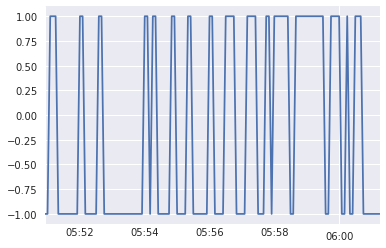

In [15]:
rt.dataresam['prediction'].plot()